<a href="https://colab.research.google.com/github/ArturGrigo/ArturGrigo/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача: создать прогностическую модель рисков беременных.

Срок: до 1 недели

Метрика: на выбор

Как сдавать: ссылку на google colab с выводами.

Обязательно вывести матрицу ошибок на тесте.

Особенности: В последних ячейках необходимо вывести

метрики и матрицу ошибок на трейне и тесте.

## Описание:
Age: Age in years when a woman is pregnant.
SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
HeartRate: A normal resting heart rate in beats per minute.
Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

Возраст: возраст в годах, когда женщина беременна.

Систолическое АД: Верхнее значение артериального давления в мм рт.ст., еще один важный атрибут во время беременности.

Диастолическое АД: более низкое значение артериального давления в мм рт.ст., еще один важный признак во время беременности.

BS: Уровень глюкозы в крови выражается в молярной концентрации, ммоль/л.

HeartRate: нормальная частота пульса в состоянии покоя в ударах в минуту.

Уровень риска: прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего признака.


In [37]:
import pandas as pd # для таблиц
import seaborn as sns # для графиков
from sklearn.ensemble import RandomForestClassifier

In [38]:
df = pd.read_csv('/content/sample_data/Maternal_Health_Risk.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [39]:
df.head(3)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk


In [40]:
df[['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate']].corr()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
Age,1.000000,0.416045,0.398026,0.473284,-0.255323,0.079798
SystolicBP,0.416045,1.000000,0.787006,0.425172,-0.286616,-0.023108
DiastolicBP,0.398026,0.787006,1.000000,0.423824,-0.257538,-0.046151
BS,0.473284,0.425172,0.423824,1.000000,-0.103493,0.142867
BodyTemp,-0.255323,-0.286616,-0.257538,-0.103493,1.000000,0.098771
HeartRate,0.079798,-0.023108,-0.046151,0.142867,0.098771,1.000000


In [41]:
# Переименовываем столбцы для удобства работы с мед терминологией
df = df.rename(columns={'Age': 'Возраст', 'SystolicBP': 'вз_артериального_давления', 'DiastolicBP': 'нз_артериального_давления',\
                        'BS': "уровень_глюкозы", 'BodyTemp': 'температура_тела', \
                        'HeartRate': 'частота_пульса', 'RiskLevel': 'уровень_риска_осложнений'})

In [42]:
 #для удобства переведем показатели температуры тела из фарингейта в цельсий
 df['температура_тела_C'] = (df['температура_тела'] - 32) * 5/9
 del df['температура_тела']

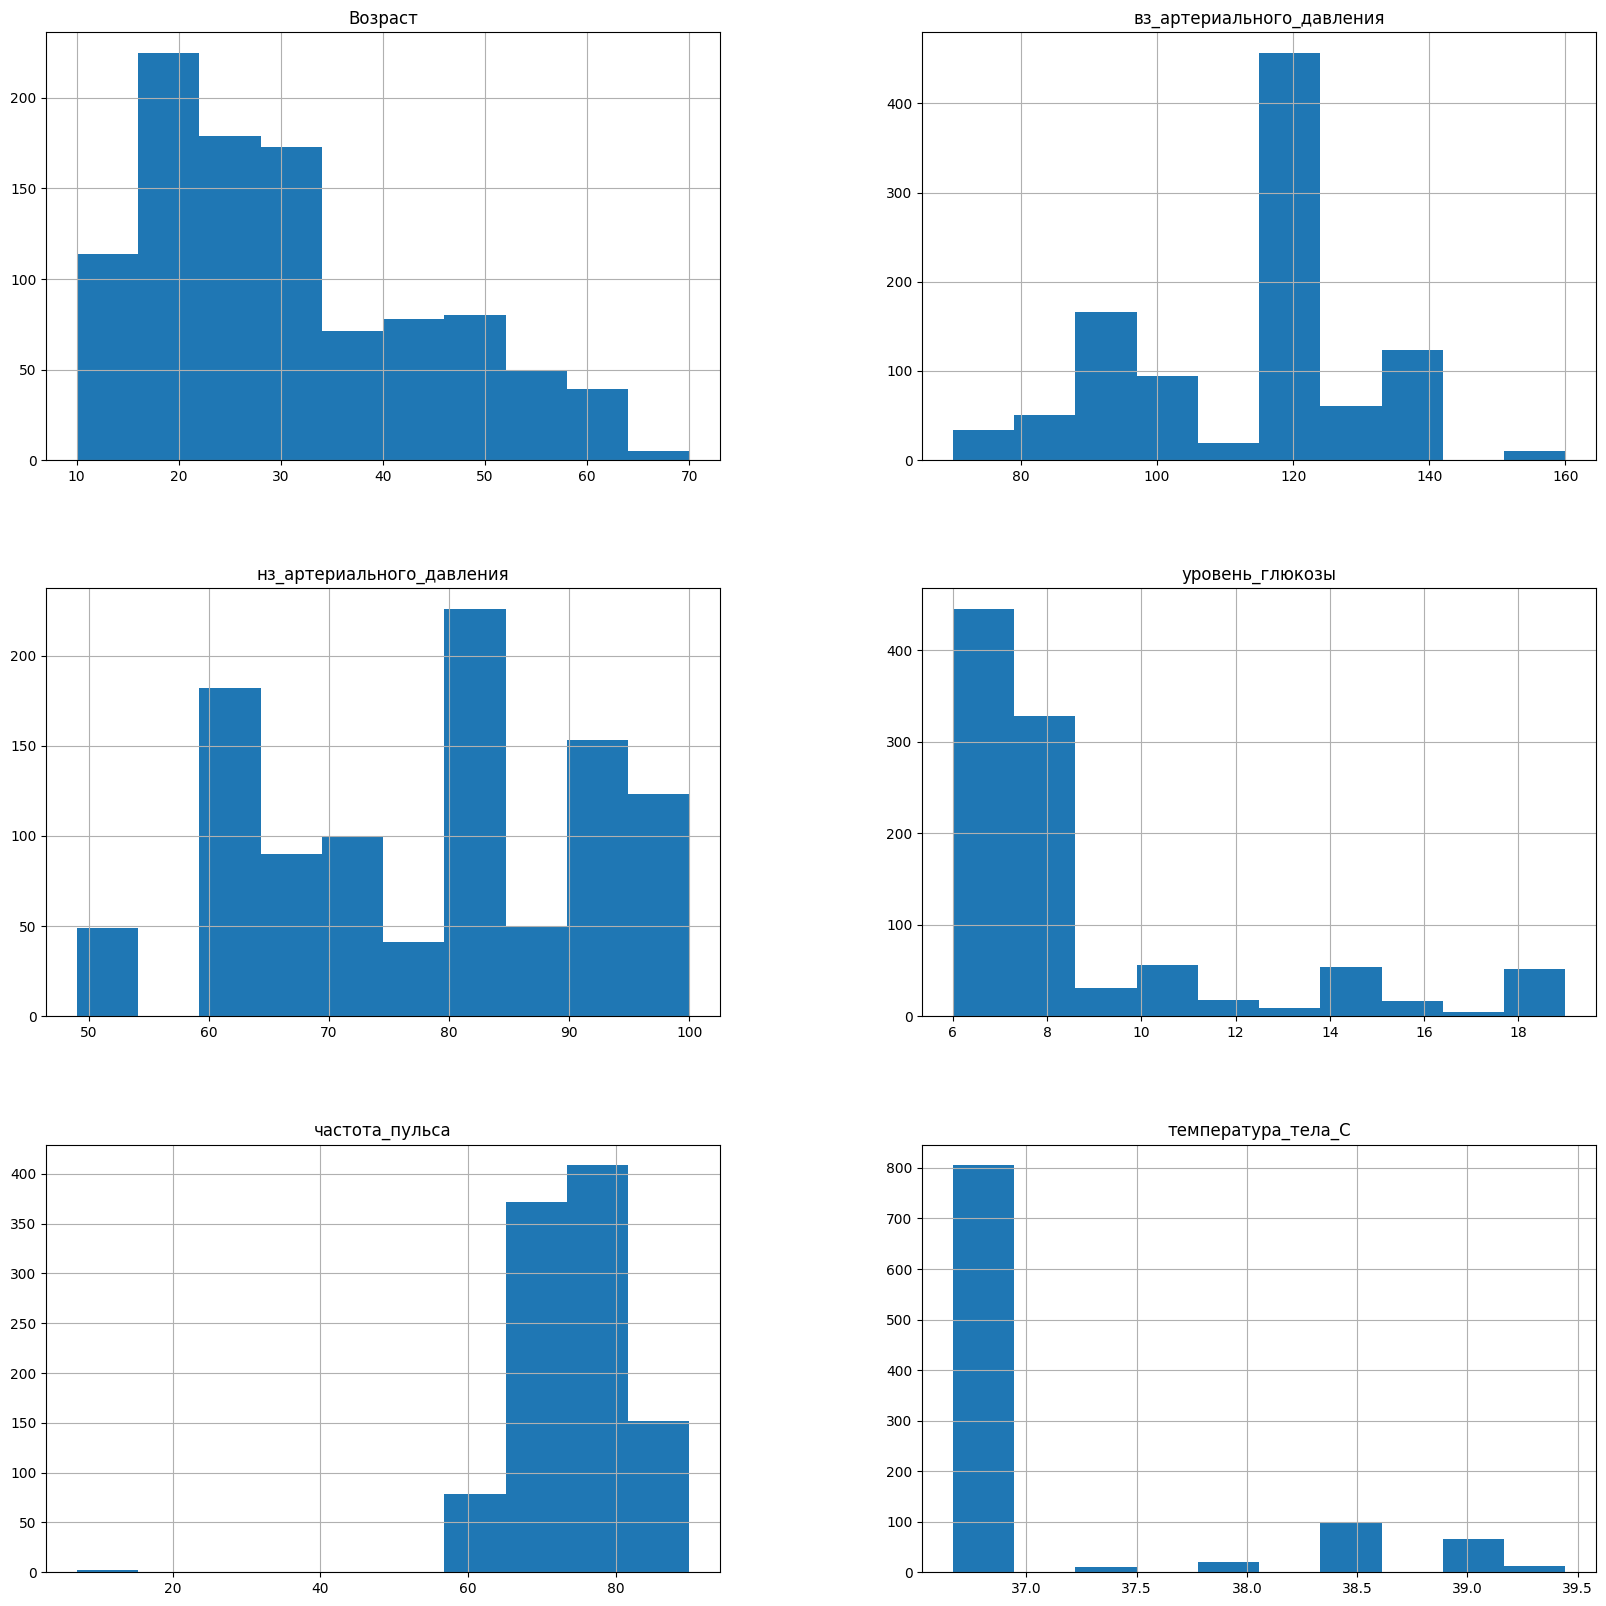

In [43]:
df.hist(figsize=(20,20))
plt.show()

### Исходя из первичного наблюдения и анализа сделаем выводы:


1.   Датасет не имеет пропусков;
2.   Типы данных опеределены верно;
3. Температура тела определена в фарингейтах;
4. Сильных взаимосвязей между признаками не наблюдается, кроме верхнего и нижнего артериального давления, что естественно;
5. Можем заметить следующие аномальные показатели:

*    частота пульса - в районе 5-10 ударов в минуту у нескольких респондентов
*   аномально маленький возраст , 10-14 лет
*   невероятно высокий уровень глюкозы

Все данные аномальные показатели вызывают сомнения в достоверности информации, будем от некоторых избавляться.






**Нормативные** **показатели**:

**Частота** **пульса** от 60 до 80

**Уровень** **глюкозы**  в норме должен быть в следующ. диапазоне 3,3-5,1 ммоль/л

Показатели считается нормальными, если систолическое давление не превышает 140 миллиметров ртутного столба, а диастолическое — 90. Оптимальное давление — 120 на 80, нормальное — 120–129 на 80–84, высоконормальное давление — 130–139 на 85–89.



In [46]:
display(df['частота_пульса'].value_counts().sort_index())
df['температура_тела_C'].value_counts().sort_index()

частота_пульса
7       2
60     74
65      5
66     87
67     12
68      2
70    271
75     19
76    131
77     96
78     46
80    117
82     19
86     55
88     59
90     19
Name: count, dtype: int64

температура_тела_C
36.666667    804
36.888889      2
37.000000      1
37.222222     10
37.777778     20
38.333333     98
38.888889     66
39.444444     13
Name: count, dtype: int64

In [49]:
display(df['уровень_глюкозы'].value_counts().sort_index())
print('-------------------------')
df['Возраст'].value_counts().sort_index()

уровень_глюкозы
6.00      21
6.10      53
6.30       2
6.40      10
6.50       1
6.60       2
6.70      33
6.80      88
6.90     113
7.00      79
7.01      15
7.10       8
7.20      20
7.50     176
7.60       1
7.70      24
7.80      45
7.90      60
8.00      22
9.00      31
10.00      4
11.00     52
12.00     18
13.00      9
15.00     54
16.00     17
17.00      5
18.00     29
19.00     22
Name: count, dtype: int64

-------------------------


Возраст
10     4
12    35
13    12
14     3
15    60
16    16
17    63
18    19
19    67
20    22
21    38
22    45
23    71
24     3
25    48
26     3
27     9
28    28
29    40
30    30
31    22
32    48
33     5
34     5
35    50
36     4
37     6
38     2
39     4
40    37
41     1
42    23
43     5
44     3
45     9
46     1
48    26
49     9
50    43
51     1
54    12
55    37
56     1
59     2
60    34
62     1
63     2
65     3
66     1
70     1
Name: count, dtype: int64

In [50]:
#посмотрим на некоторые математические значения таблицы
df.describe()

,Возраст,вз_артериального_давления,нз_артериального_давления,уровень_глюкозы,частота_пульса,температура_тела_C
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,74.301775,37.036160
std,13.474386,18.403913,13.885796,3.293532,8.088702,0.761880
min,10.000000,70.000000,49.000000,6.000000,7.000000,36.666667
25%,19.000000,100.000000,65.000000,6.900000,70.000000,36.666667
50%,26.000000,120.000000,80.000000,7.500000,76.000000,36.666667
75%,39.000000,120.000000,90.000000,8.000000,80.000000,36.666667
max,70.000000,160.000000,100.000000,19.000000,90.000000,39.444444


Исходя из значений выше, можем заметить что:

1) Уровень глюкозы в среднем на 3,7 моль превышает максимальное значения в норме;

2)Частота пульса, температура тела, артериальное давление у большинства  находятся в норме.

In [52]:
# Посмотрим на целевой признак
df['уровень_риска_осложнений'].value_counts()
# нужно удалить аномалии
# так как 3 класса то будем использовать следующие методы машинного обучнеия
#Случайный лес (Random Forest): Random Forest - это ансамблевый метод, который хорошо работает для двоичной и для многоклассовой классификации.

#Градиентный бустинг (Gradient Boosting):
# Метод градиентного бустинга, например, XGBoost или LightGBM, также эффективен для классификации на несколько классов.

уровень_риска_осложнений
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64



Для преобразования целевого признака с текстовыми значениями в числовой формат (который может быть обработан алгоритмами машинного обучения), ,будем использовать метод кодирования категориальных переменных. Один из распространенных подходов - это применение One-Hot Encoding.

- **One-Hot Encoding**: Этот метод создает новый бинарный столбец для каждой категории целевого признака. В вашем случае, это преобразует "low risk", "mid risk", "high risk" в три столбца, каждый из которых будет содержать 1 или 0 в зависимости от соответствия категории.
